In [9]:
from ggplot import *
import pandas as pd
import numpy as np


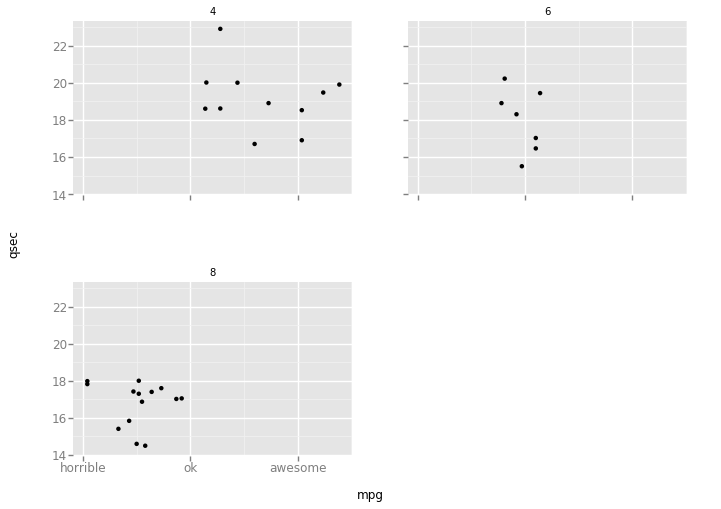

<ggplot: (13430206)>
